In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# import plotly.graph_objs as go
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # -기호 깨짐 방지

In [53]:
df = pd.read_csv('./src/eoraptor.csv')
# df = pd.read_csv('eoraptor.csv')
df

,case,site,sex,age,head_length,skull_width,total_length,tail_length,foot_length,earconch,eye,chest,belly
0,1,1,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,100,7,m,1.0,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0
100,101,7,m,1.0,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0
101,102,7,f,6.0,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0
102,103,7,m,4.0,91.5,55.2,82.5,36.5,62.9,45.9,15.4,25.0,29.0


# 결측치 확인 및 처리

In [54]:
df[df.isnull().any(axis=1)]

,case,site,sex,age,head_length,skull_width,total_length,tail_length,foot_length,earconch,eye,chest,belly
40,41,2,f,5.0,88.4,57.0,83.0,36.5,NaN,40.3,15.9,27.0,30.5
43,44,2,m,NaN,85.1,51.5,76.0,35.5,70.3,52.6,14.4,23.0,27.0
45,46,2,m,NaN,91.4,54.4,84.0,35.0,72.8,51.2,14.4,24.5,35.0


In [55]:
df.fillna(0, inplace=True)
df.drop('case', axis=1, inplace=True)

In [56]:
# NaN 값이 있는지 확인, 있으면 0으로 채우고 시작

from sklearn.metrics.pairwise import cosine_similarity


def similar_users(user_id, matrix, k=10):
    # 선택된 사용자의 평가정보
    user = matrix[matrix.index == user_id]
    # 나머지 사용자의 평가정보
    other_user = matrix[matrix.index != user_id]

    # 코사인 유사도 계산
    similarity = cosine_similarity(user, other_user)[0]
    # 다른 사용자 ID 인덱스 생성
    other_user_list = other_user.index

    # 다른 사용자와의 유사도 딕셔너리
    user_simirality = dict(zip(other_user_list, similarity))
    user_simirality = pd.Series(user_simirality)
    
    # 상위 k명 찾기
    top_user = user_simirality.sort_values(ascending=False)[:k]
    return top_user


def recommend_contents(user_id, matrix, col, k=10, n=10):
    # 성향이 비슷한 사용자 상위 k명 찾기
    top_user = similar_users(user_id, matrix, k=k)
    # 성향이 비슷한 사용자의 사용자-콘텐츠 행렬
    top_matrix = matrix.loc[top_user[:n].index]
    return top_matrix[col].mean() 
    
recommend_contents(40, df, col='foot_length',k=10, n=10)

ValueError: could not convert string to float: 'f'

In [47]:
missing_index = df[df['foot_length'] == 0].index

for idx in missing_index:
    df.loc[idx, 'foot_length'] = recommend_contents(idx, df, col='foot_length', k=10, n=10)

df.loc[missing_index]


,site,sex,age,head_length,skull_width,total_length,tail_length,foot_length,earconch,eye,chest,belly
40,2,1,5.0,88.4,57.0,83.0,36.5,63.78,40.3,15.9,27.0,30.5


In [43]:
df['sex'] = df['sex'].apply(lambda x: 0 if x == 'm' else 1)

In [57]:
df.dropna(axis=0, inplace=True)

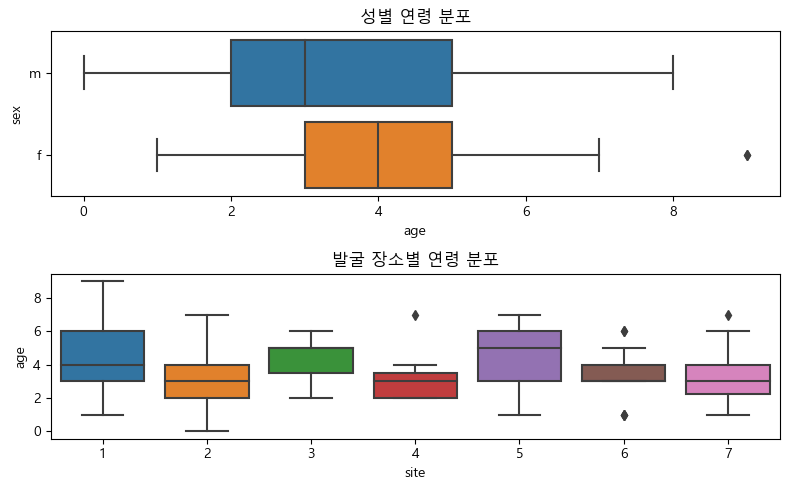

In [58]:
fig, axes = plt.subplots(2, figsize=(8, 5))

sns.boxplot(x='age', y='sex', data=df, ax=axes[0])
axes[0].set_title('성별 연령 분포')

sns.boxplot(x='site', y='age', data=df, ax=axes[1])
axes[1].set_title('발굴 장소별 연령 분포')

plt.tight_layout()
plt.show()

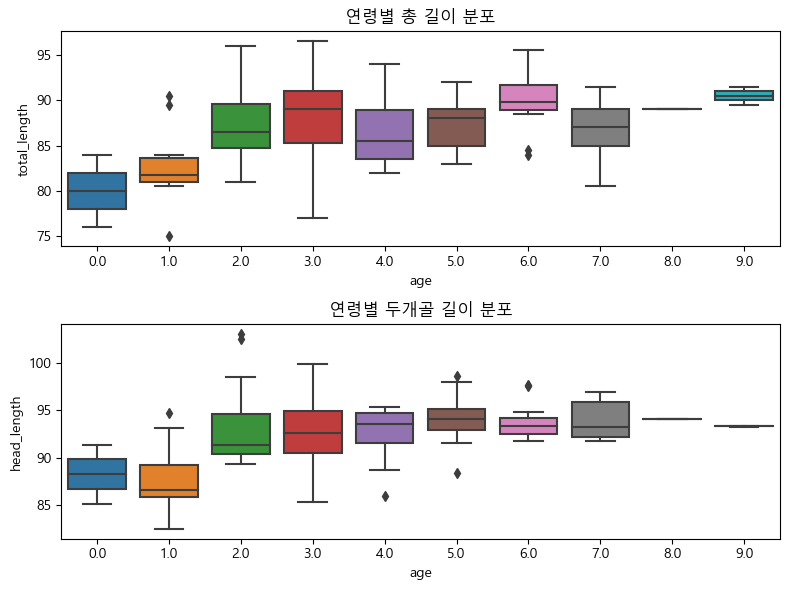

In [59]:
fig, axes = plt.subplots(2, figsize=(8, 6))

sns.boxplot(x='age', y='total_length', data=df, ax=axes[0])
axes[0].set_title('연령별 총 길이 분포')

sns.boxplot(x='age', y='head_length', data=df, ax=axes[1])
axes[1].set_title('연령별 두개골 길이 분포')

plt.tight_layout()
plt.show()

# 상관관계 히트맵

<Axes: >

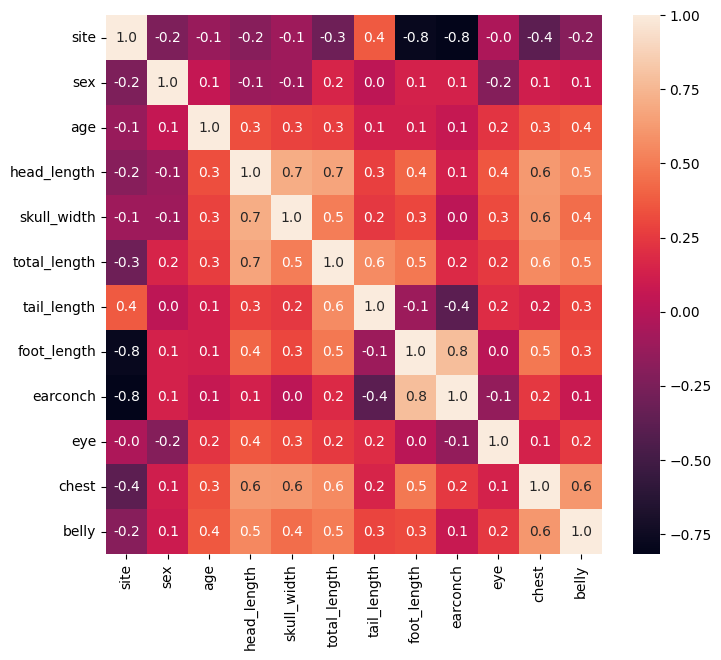

In [45]:
plt.figure(figsize=(8,7))
sns.heatmap(df.corr(), annot=True, fmt='.1f')

In [46]:
df.corr().abs().unstack().sort_values(ascending=False).iloc[10:40]

age           age             1.000000
belly         belly           1.000000
site          earconch        0.818580
earconch      site            0.818580
              foot_length     0.782415
foot_length   earconch        0.782415
              site            0.781489
site          foot_length     0.781489
skull_width   head_length     0.705901
head_length   skull_width     0.705901
total_length  head_length     0.670402
head_length   total_length    0.670402
              chest           0.621068
chest         head_length     0.621068
skull_width   chest           0.613842
chest         skull_width     0.613842
belly         chest           0.609757
chest         belly           0.609757
total_length  tail_length     0.563586
tail_length   total_length    0.563586
chest         total_length    0.556094
total_length  chest           0.556094
head_length   belly           0.545438
belly         head_length     0.545438
total_length  skull_width     0.506382
skull_width   total_lengt

<Axes: >

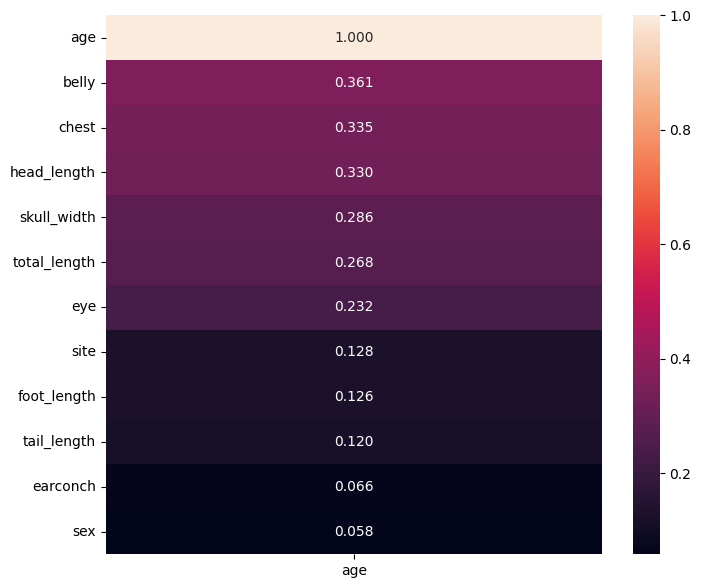

In [47]:
plt.figure(figsize=(8,7))
sns.heatmap(df.corr()['age'].abs().sort_values(ascending=False).to_frame(), annot=True, fmt='.3f')

# belly, chest 상관관계 그래프

### sex 기준 상관관계

<Figure size 800x500 with 0 Axes>

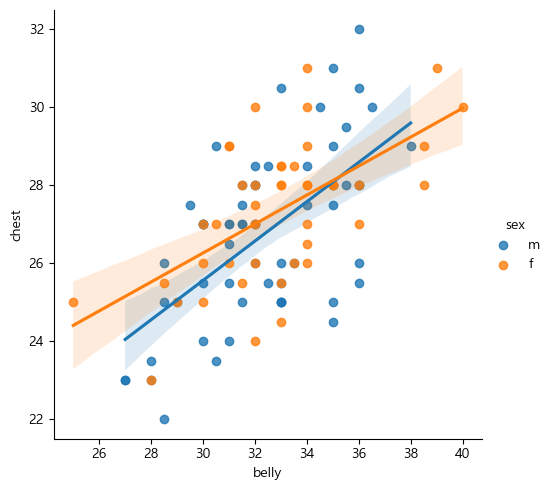

In [60]:
plt.figure(figsize=(8, 5))
sns.lmplot(df, x='belly', y='chest', hue='sex')
plt.show()

### age 기준 상관관계

In [61]:
fig = go.Figure()

# 각 'age' 그룹에 대해 산점도 추가
for age in range(1, 10):
    # 'age' 열의 값에 따라 데이터 분리
    df_age = df[df['age'] == age]

    fig.add_trace(go.Scatter(
        x=df_age['belly'],
        y=df_age['chest'],
        mode='markers',
        name=f'Age {age}'
    ))

fig.update_layout(
    width=800,
    height=700,
    xaxis_title="belly",
    yaxis_title="chest",
)

fig.show()


In [62]:
df_tmp = df.copy()
df_tmp.sort_values(by='age', inplace=True)

fig = px.scatter(df_tmp, x="belly", y="chest", size="chest", 
                 color="sex", 
                 animation_frame="age", 
                 range_x=[df_tmp['belly'].min(), df_tmp['belly'].max()], 
                 range_y=[df_tmp['chest'].min(), df_tmp['chest'].max()])

fig.update_layout(
    width=800,  
    height=600,  
)

# Remove the play button
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000
fig.show()

# 두개골의 크기 관계

### sex 기준 상관관계

<Figure size 800x500 with 0 Axes>

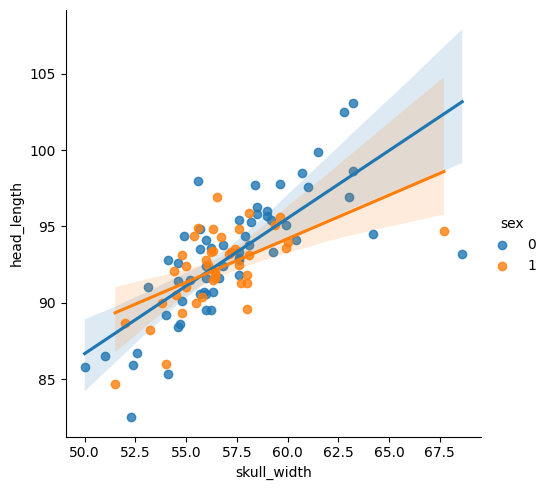

In [13]:
plt.figure(figsize=(8, 5))
sns.lmplot(df, x='skull_width', y='head_length', hue='sex')
plt.show()

# head와 skull로 본 age와의 상관관계

In [14]:
fig = go.Figure()

# 각 'age' 그룹에 대해 산점도 추가
for age in range(1, 10):
    # 'age' 열의 값에 따라 데이터 분리
    df_age = df[df['age'] == age]

    fig.add_trace(go.Scatter(
        x=df_age['skull_width'],
        y=df_age['head_length'],
        mode='markers',
        name=f'Age {age}'
    ))

fig.update_layout(
    width=800,
    height=700,
    xaxis_title="skull_width",
    yaxis_title="head_length",
)

fig.show()


In [70]:
df_tmp = df.copy()
df_tmp.sort_values(by='age', inplace=True)

fig = px.scatter(df_tmp, x="skull_width", y="head_length", size="head_length", 
                 color="sex",
                 animation_frame="age", 
                 range_x=[df_tmp['skull_width'].min(), df_tmp['skull_width'].max()], 
                 range_y=[df_tmp['head_length'].min(), df_tmp['head_length'].max()])

fig.update_layout(
    width=800,  
    height=600,  
)

# Remove the play button
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000
fig.show()

# Split, Scaler

In [32]:
X = df[['head_length', 'skull_width', 'total_length', 'chest', 'belly', 'eye']]
y = df.iloc[:, 2]


X[['head_length', 'skull_width']].apply(lambda x: x * 10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train

,head_length,skull_width,total_length,chest,belly,eye
76,93.6,56.2,84.0,25.0,35.0,16.2
19,94.8,56.3,89.0,27.0,36.0,15.5
27,93.8,56.8,87.0,27.0,30.0,15.3
51,97.6,61.0,93.5,28.5,32.5,15.8
61,91.3,58.0,90.5,27.0,32.0,16.0
...,...,...,...,...,...,...
78,85.8,50.0,81.0,22.0,28.5,14.8
9,91.8,58.0,89.5,27.5,32.0,14.4
75,92.4,56.8,89.0,26.0,33.0,17.8
12,95.1,59.9,89.5,27.0,32.0,15.8


In [33]:
std = StandardScaler()
std_scaler_col = ['head_length', 'skull_width', 'total_length', 'chest', 'belly', 'eye']
X_train[std_scaler_col] = std.fit_transform(X_train[std_scaler_col])
X_test[std_scaler_col] = std.transform(X_test[std_scaler_col])

X_train

,head_length,skull_width,total_length,chest,belly,eye
76,0.250758,-0.231903,-0.902074,-0.930751,0.824067,0.912015
19,0.630284,-0.194925,0.430103,0.038060,1.180146,0.267156
27,0.314012,-0.010037,-0.102768,0.038060,-0.956325,0.082910
51,1.515844,1.543028,1.629061,0.764669,-0.066129,0.543524
61,-0.476666,0.433696,0.829756,0.038060,-0.244168,0.727770
...,...,...,...,...,...,...
78,-2.216160,-2.524522,-1.701379,-2.383969,-1.490443,-0.377703
9,-0.318531,0.433696,0.563320,0.280263,-0.244168,-0.746194
75,-0.128768,-0.010037,0.430103,-0.446345,0.111910,2.385979
12,0.725165,1.136273,0.563320,0.038060,-0.244168,0.543524


# 모델_1번에 최적의 파라미터로 학습 및 평가

MAE: 1.2560177028195103
MSE: 2.6943499948124576
RMSE: 1.6414475303257359


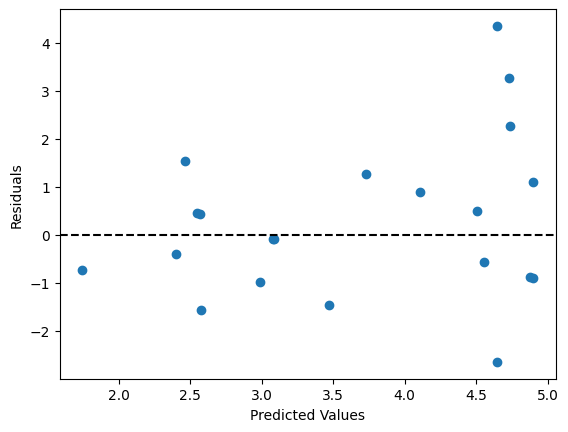

In [24]:
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [3, 5, 7],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 2, 4]}

rf = RandomForestRegressor(random_state=1)
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
gs.fit(X_train, y_train)
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

# 잔차 그래프 그리기
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# 모델_1번의 학습곡선

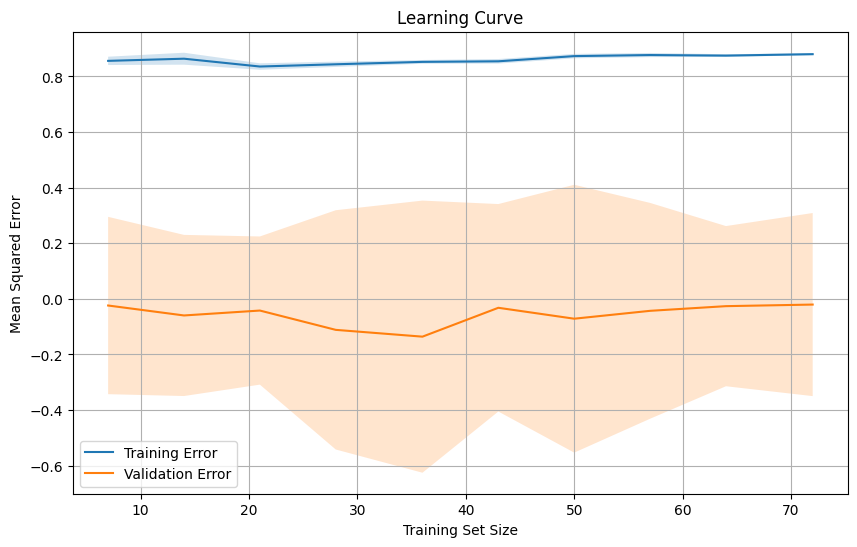

In [32]:
rf = RandomForestRegressor(random_state=1, n_jobs=-1)

sizes, train_scores, val_scores = learning_curve(estimator=rf, X=X_train, y=y_train,
                                                train_sizes=np.linspace(0.1, 1.0, 10),
                                                cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(sizes, train_mean, label='Training Error')
plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(sizes, val_mean, label='Validation Error')
plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# 모델_2번에 최적의 파라미터로 학습 및 평가

MAE: 1.3689477735846585
MSE: 3.067811657287233
RMSE: 1.751516958892272


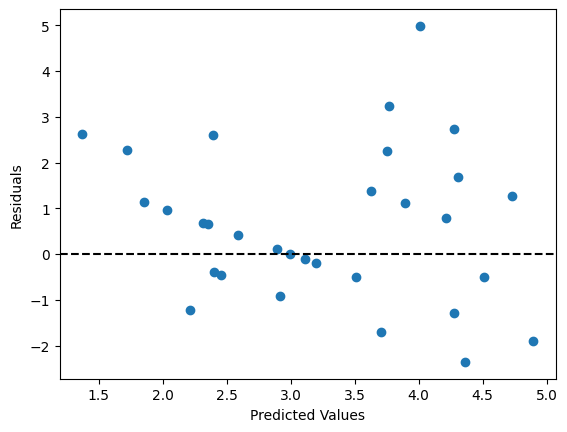

In [23]:
from sklearn.svm import SVR

param_grid = {'C': [0.1, 1, 10],
              'epsilon': [0.1, 0.2, 0.3],
              'kernel': ['linear', 'rbf', 'poly']}

svm = SVR()
gs = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
gs.fit(X_train, y_train)
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

# 잔차 그래프 그리기
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()


# 모델_2번 학습곡선

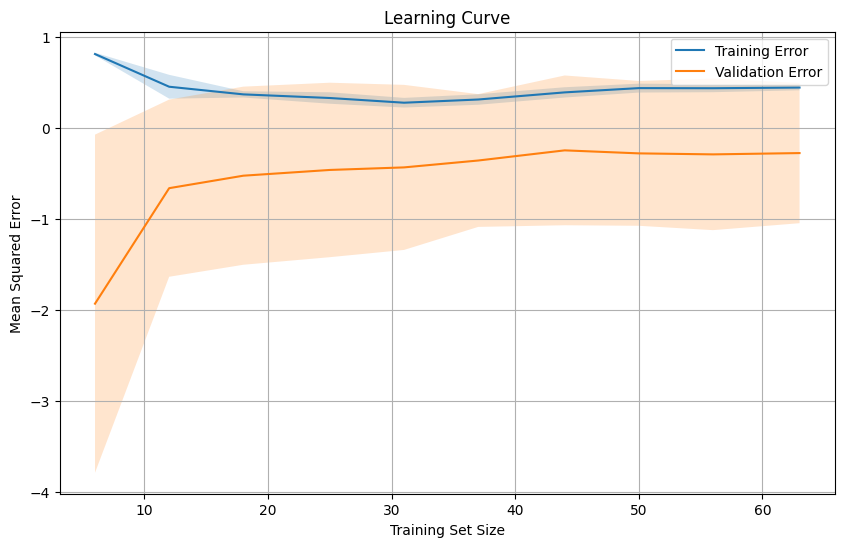

In [25]:
svr = SVR()
sizes, train_scores, val_scores = learning_curve(estimator=svr, X=X_train, y=y_train,
                                                train_sizes=np.linspace(0.1, 1.0, 10),
                                                cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(sizes, train_mean, label='Training Error')
plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(sizes, val_mean, label='Validation Error')
plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# 모델_3번의 모델에 최적의 파라미터로 학습 및 평가

MAE: 1.6646307591469056
MSE: 4.168389516917063
RMSE: 2.041663419106358


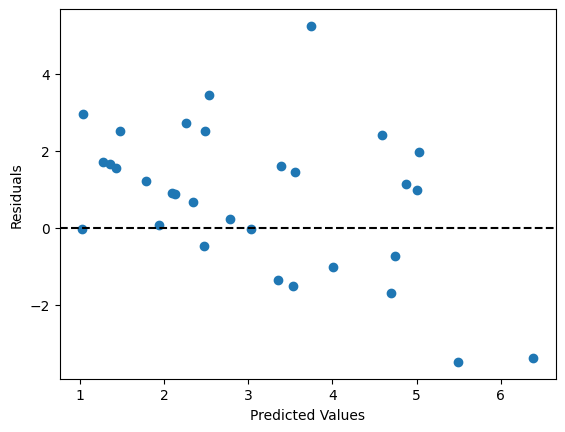

In [18]:
# 모델 학습 및 예측
xgb_pipe = make_pipeline(xgb.XGBRegressor(objective='reg:squarederror', random_state=1, n_jobs=-1))
param_grid = {'xgbregressor__max_depth': [3, 5, 7],
              'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.15],
              'xgbregressor__n_estimators': [100, 300, 500],
              'xgbregressor__min_child_weight': [1, 3, 5],
              'xgbregressor__colsample_bytree': [0.5, 0.7],
              'xgbregressor__reg_alpha': [0, 0.03, 0.1],
              'xgbregressor__reg_lambda': [0.1, 0.5, 1],
              'xgbregressor__objective': ['reg:squarederror']}

gs = GridSearchCV(estimator=xgb_pipe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
gs.fit(X_train, y_train)
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

# 잔차 그래프 그리기
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# 모델_3번의 학습곡선

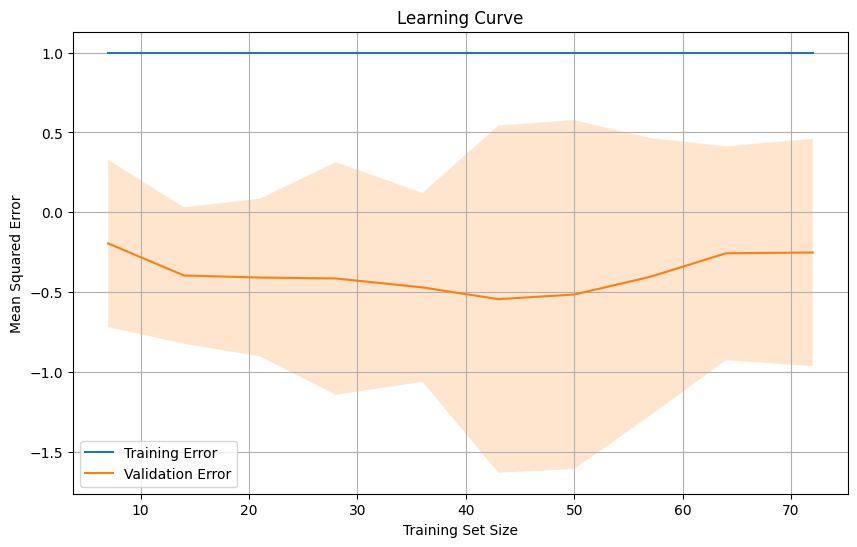

In [31]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=1, n_jobs=-1)

sizes, train_scores, val_scores = learning_curve(estimator=xgb, X=X_train, y=y_train,
                                                train_sizes=np.linspace(0.1, 1.0, 10),
                                                cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(sizes, train_mean, label='Training Error')
plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(sizes, val_mean, label='Validation Error')
plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [9]:
df

,site,sex,age,head_length,skull_width,total_length,tail_length,foot_length,earconch,eye,chest,belly
0,1,0,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,1,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,1,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,1,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,1,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99,7,0,1.0,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0
100,7,0,1.0,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0
101,7,1,6.0,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0
102,7,0,4.0,91.5,55.2,82.5,36.5,62.9,45.9,15.4,25.0,29.0


In [22]:
df_col = df.iloc[:, 2:].columns
df_col

Index(['sex', 'head_length', 'skull_width', 'total_length', 'tail_length',
       'foot_length', 'earconch', 'eye', 'chest', 'belly'],
      dtype='object')

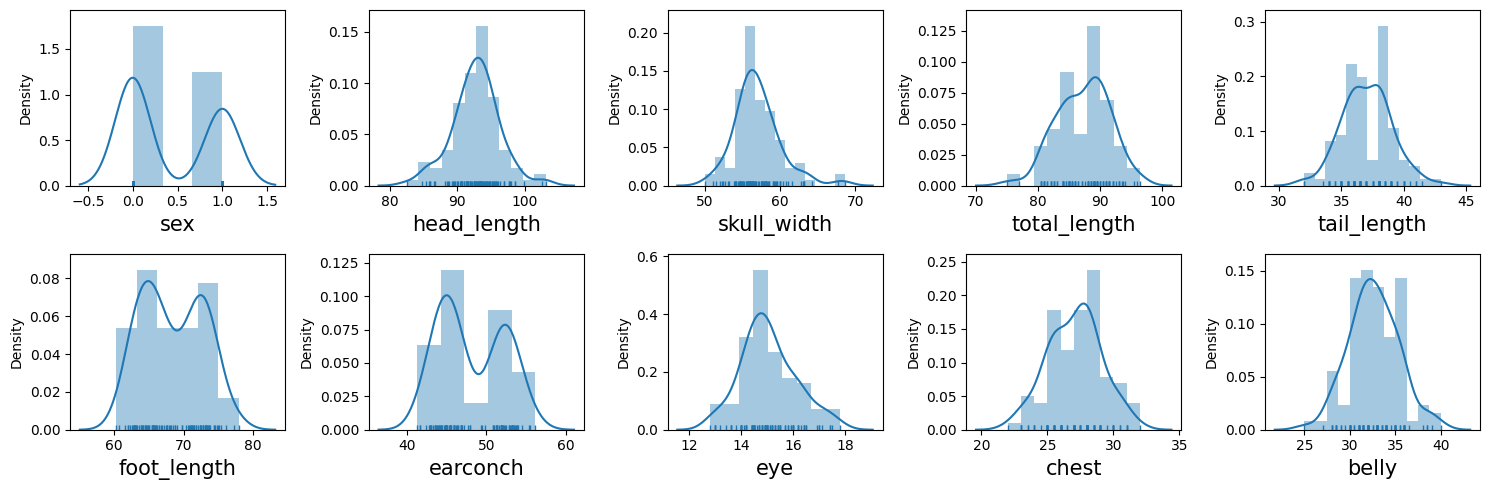

In [23]:
plt.figure(figsize= (15,5))

for i in range(len(df_col)) :
    plt.subplot(2,5,i+1)
    sns.distplot(df[df_col[i]], hist= True, rug= True)
    plt.xlabel(df_col[i], fontsize= 15)
    plt.xticks(fontsize= 10)
    plt.yticks(fontsize= 10)
    plt.tight_layout()
    
plt.show()   

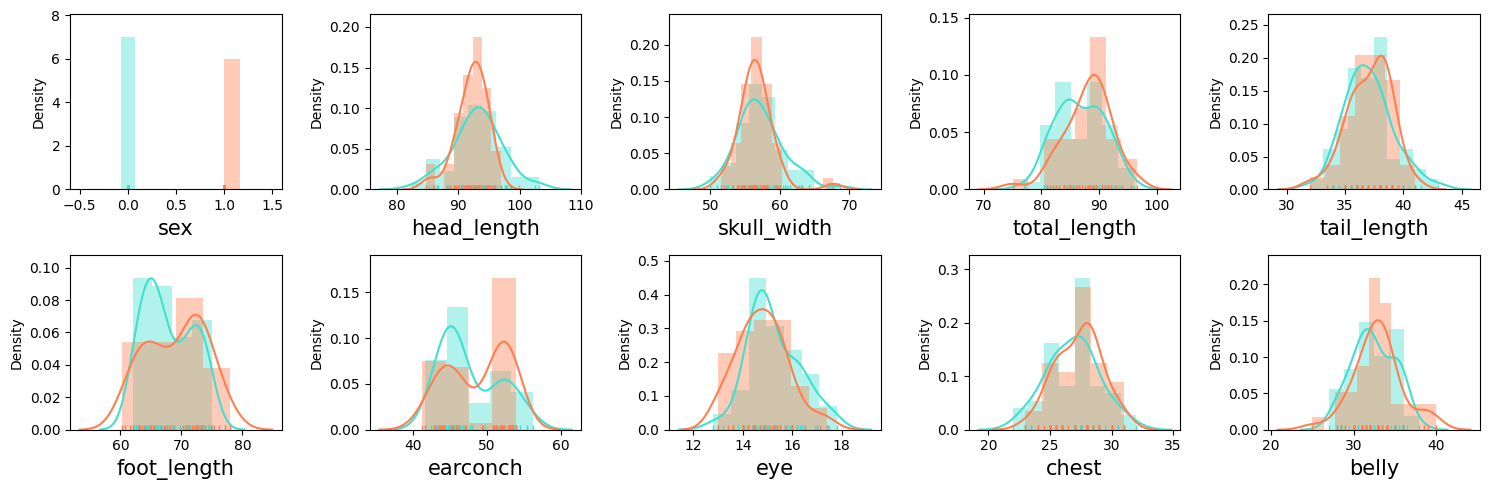

In [24]:
df_m = df[df['sex'] == 0]
df_f = df[df['sex'] == 1]

plt.figure(figsize= (15,5))

for i in range(10) :
    plt.subplot(2,5,i+1)
    sns.distplot(df_m[df_col[i]], hist= True, rug= True, color= 'turquoise')
    sns.distplot(df_f[df_col[i]], hist= True, rug= True, color= 'coral')
    plt.xlabel(df_col[i], fontsize= 15)
    plt.xticks(fontsize= 10)
    plt.yticks(fontsize= 10)
    plt.tight_layout()
    
plt.show()   

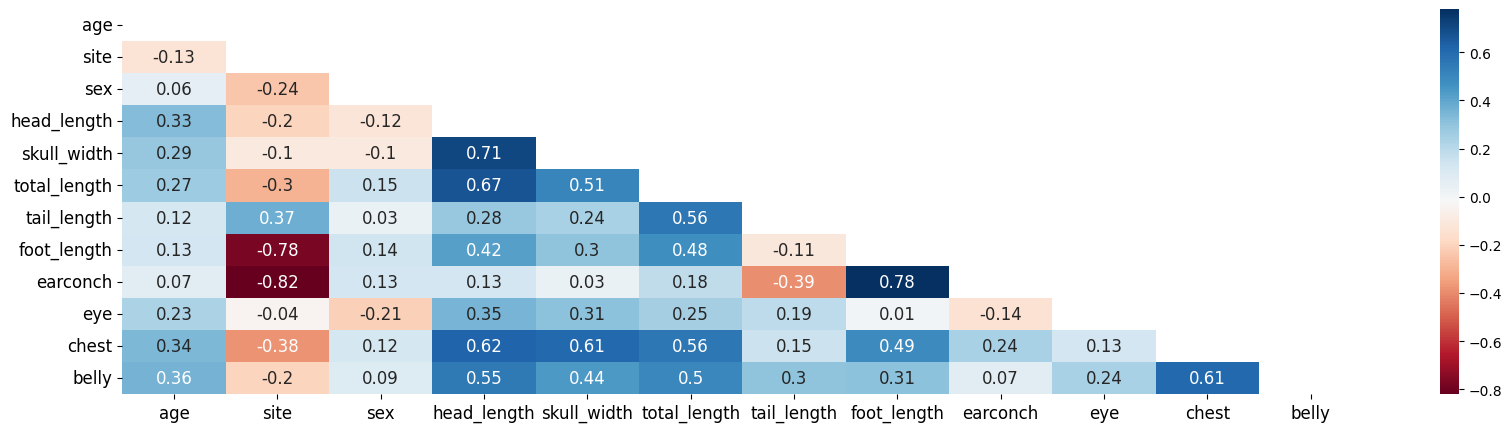

In [21]:
df = df.reindex(columns= ['age','site','sex','head_length','skull_width','total_length','tail_length','foot_length','earconch','eye','chest','belly'])

mask = np.triu(df.corr())

plt.figure(figsize= (20,5))

sns.heatmap(df.corr().round(2), annot= True, annot_kws= {'size':12}, cmap= 'RdBu', mask= mask)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)

plt.show()